In [95]:
# 이 폴더가 깃허브 어떤 브랜치에 있는지 먼저 확인하고 작업할 것  
# 삼성전자        131
# 현대차         130
# POSCO       110
# 현대모비스       102
# 삼성전자우        87
# 한국전력         84
# SK하이닉스       83
# 신한지주         82
# LG화학         76
# 삼성생명         60
# NAVER        58
# 위종목에 대해 2009~2018년 데이터를 수집 후 , 로그 수익률로 변형
# 2019년 데이터도 받야야함 

1.삼성전자 = 005930
2.현대차 = 005380
3.POSCO = 005490
4.현대모비스 = 012330
5.한국전력 = 015760
6. SK하이닉스 = 000660
7.신한지주 = 055550
8.LG화학 = 051915
9.삼성생명 = 032830
10. NAVER = 035420

[005930, 005380, 05490, 012330, 015760, 00660, 055550, 051915, 03280, 035420]

### 시계열 데이터 분석 + ARIMA 모델 사용

In [2]:
import yfinance as yf
import pmdarima as pm
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pmdarima.arima import ndiffs
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# 1. 데이터 수집(시가총액 10위)
stocks = ['삼성전자','현대차', 'POSCO', '현대모비스', '한국전력','SK하이닉스', '신한지주', 'LG화학', '삼성생명', 'NAVER']
ticker = ['005930', '005380', '005490', '012330', '015760', '000660', '055550', '051915', '032830', '035420']
st = {}

for i, t in enumerate(ticker):
    symbol = t+'.KS'
    data = yf.download(symbol , '2009-01-01', '2019-12-31')
    st[stocks[i]] = data

st

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{'삼성전자':                Open     High      Low    Close     Adj Close    Volume
 Date                                                                  
 2009-01-02   9070.0   9400.0   8850.0   9400.0   7192.033203  22978400
 2009-01-05   9600.0   9740.0   9470.0   9520.0   7283.847656  30460450
 2009-01-06   9640.0  10040.0   9590.0   9960.0   7620.495605  45072450
 2009-01-07  10100.0  10480.0   9980.0  10480.0   8018.353516  41286200
 2009-01-08  10360.0  10380.0  10060.0  10160.0   7773.517578  30614600
 ...             ...      ...      ...      ...           ...       ...
 2019-12-23  56100.0  56400.0  55100.0  55500.0  49987.878906   9839252
 2019-12-24  55600.0  55700.0  54800.0  55000.0  49537.542969  11868463
 2019-12-26  54700.0  55400.0  54400.0  55400.0  49897.808594   9645034
 2019-12-27  55700.0  56900.0  55500.0  56500.0  51215.835938  12313056
 2019-12-30  56200.0  56600.0  55700.0  55800.0  50581.296875   8356767
 
 [2718 rows x 6 columns],
 '현대차':                 Open

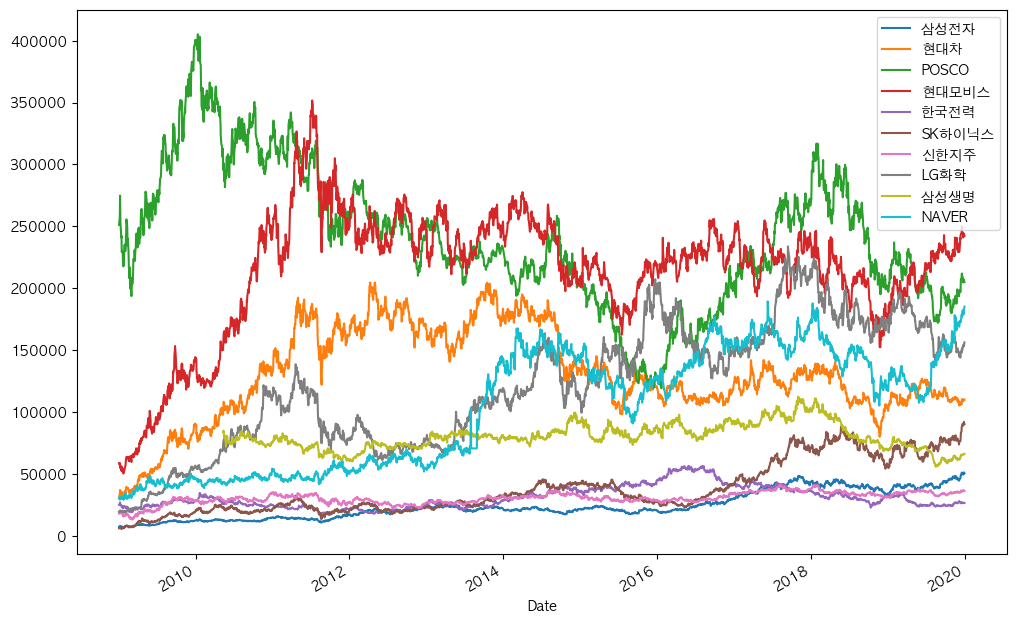

In [4]:
# 2. Adj Close 추세 확인
rc('font', family='AppleGothic')

plt.figure(figsize=(12, 8))
for k, v in st.items():
    v['Adj Close'].plot(label=k)

plt.legend()

/opt/homebrew/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


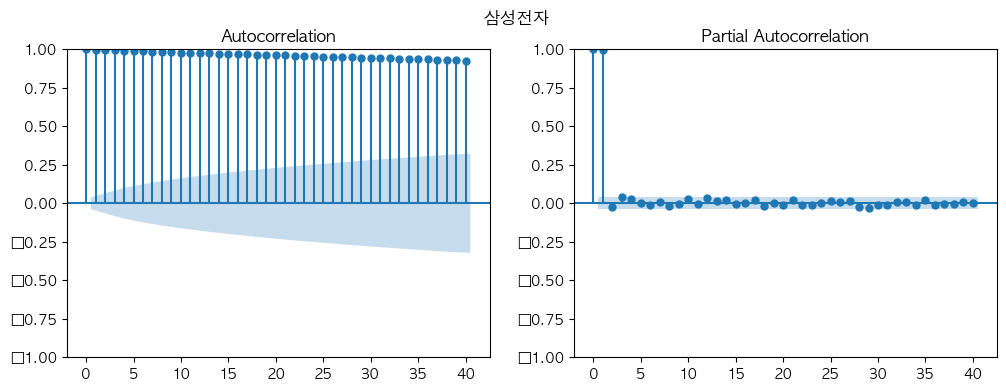

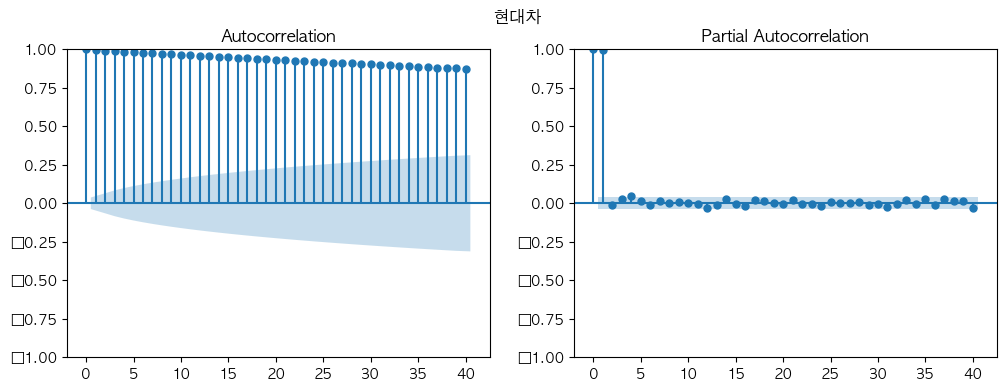

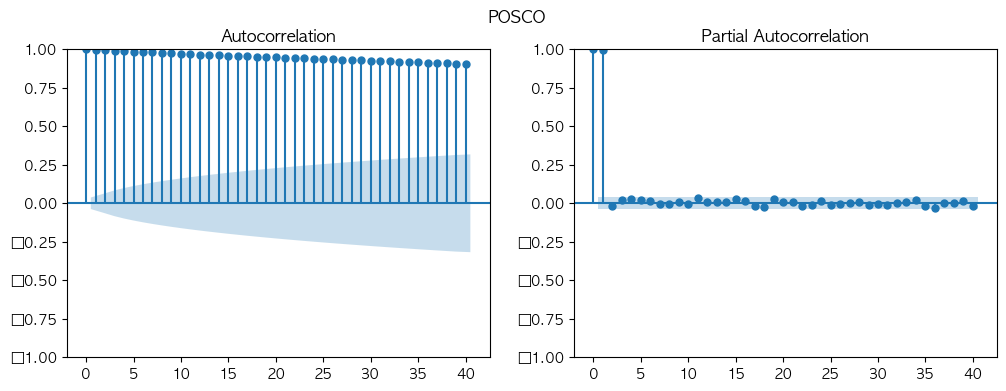

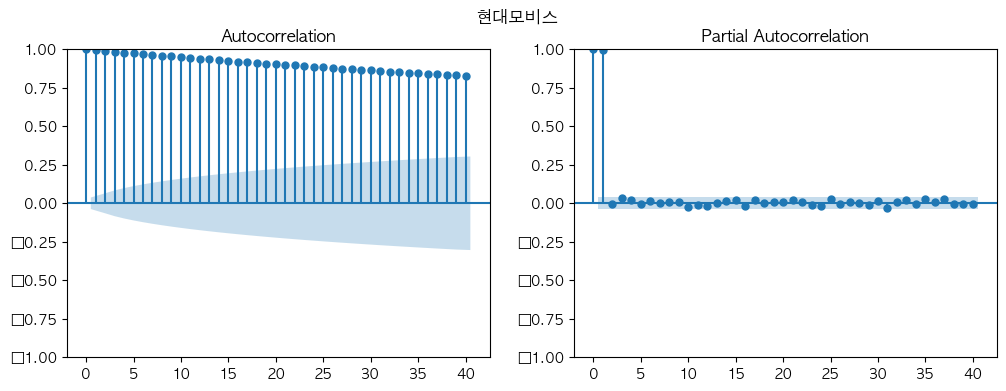

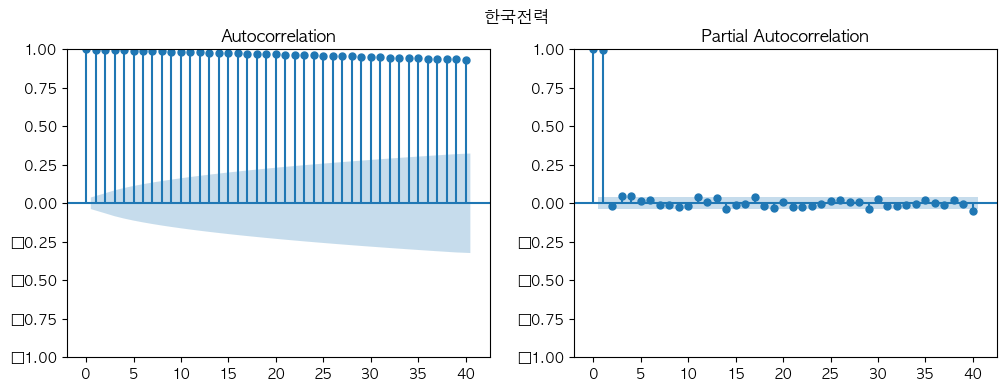

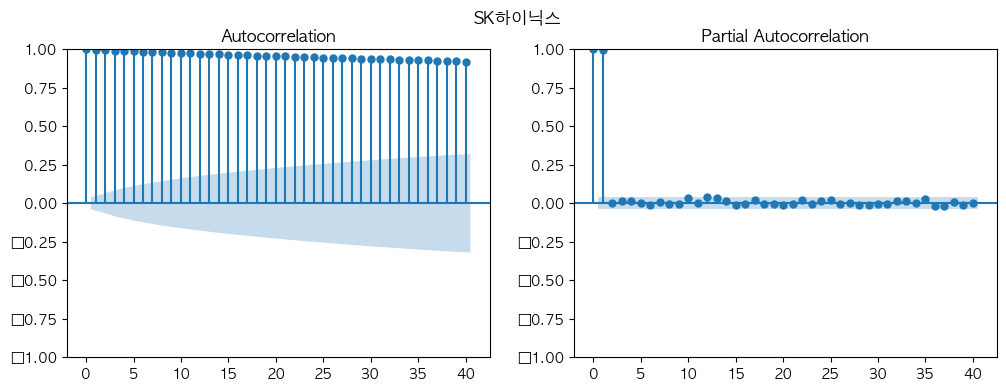

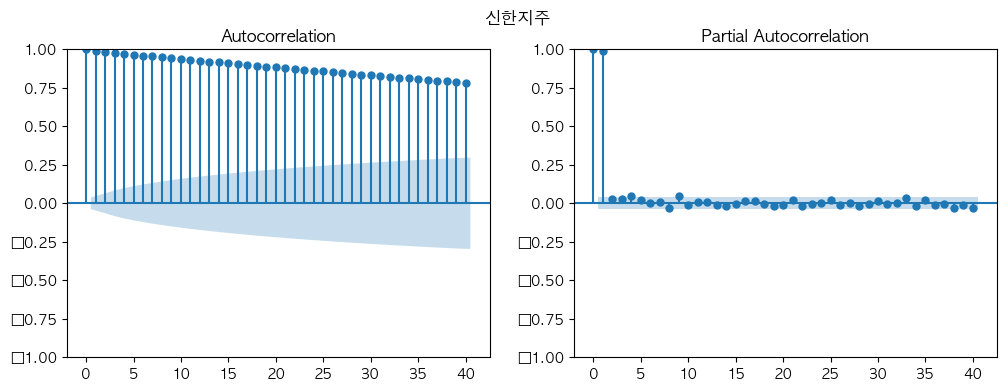

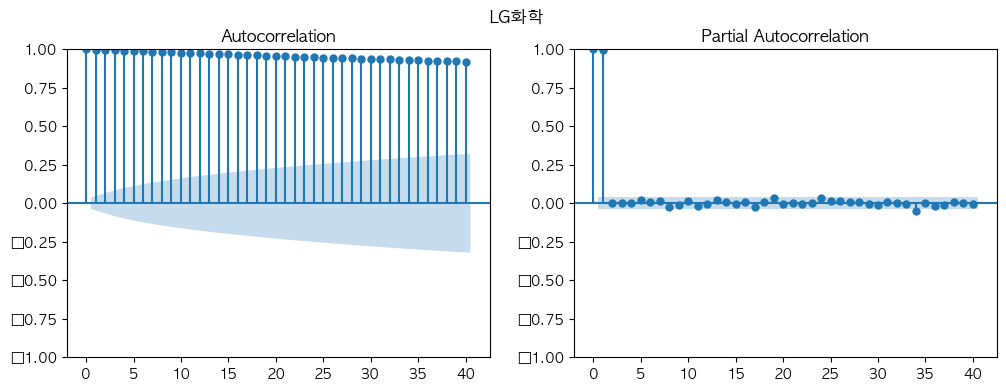

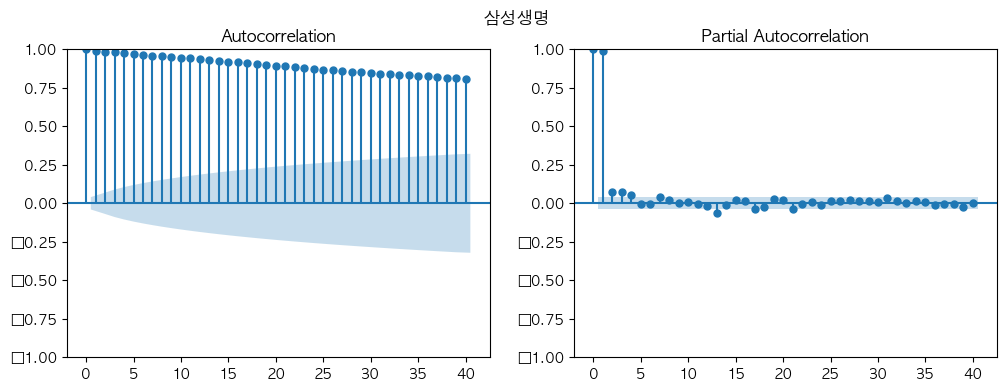

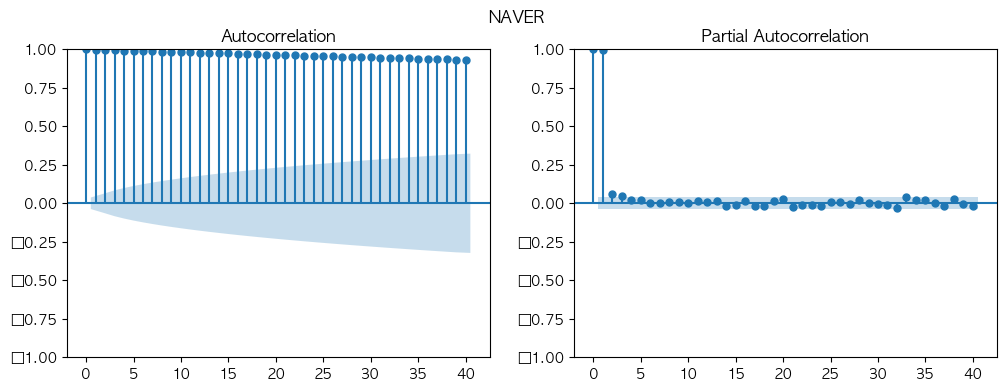

In [76]:
# 3. 데이터 분리
for k, v in st.items(): 

    # 4. ACF를 통한 정상성, 비정상성 확인
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle(k)
    plot_acf(v['Adj Close'],lags=40 ,ax=ax[0])
    plot_pacf(v['Adj Close'], lags=40, ax=ax[1])

/opt/homebrew/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


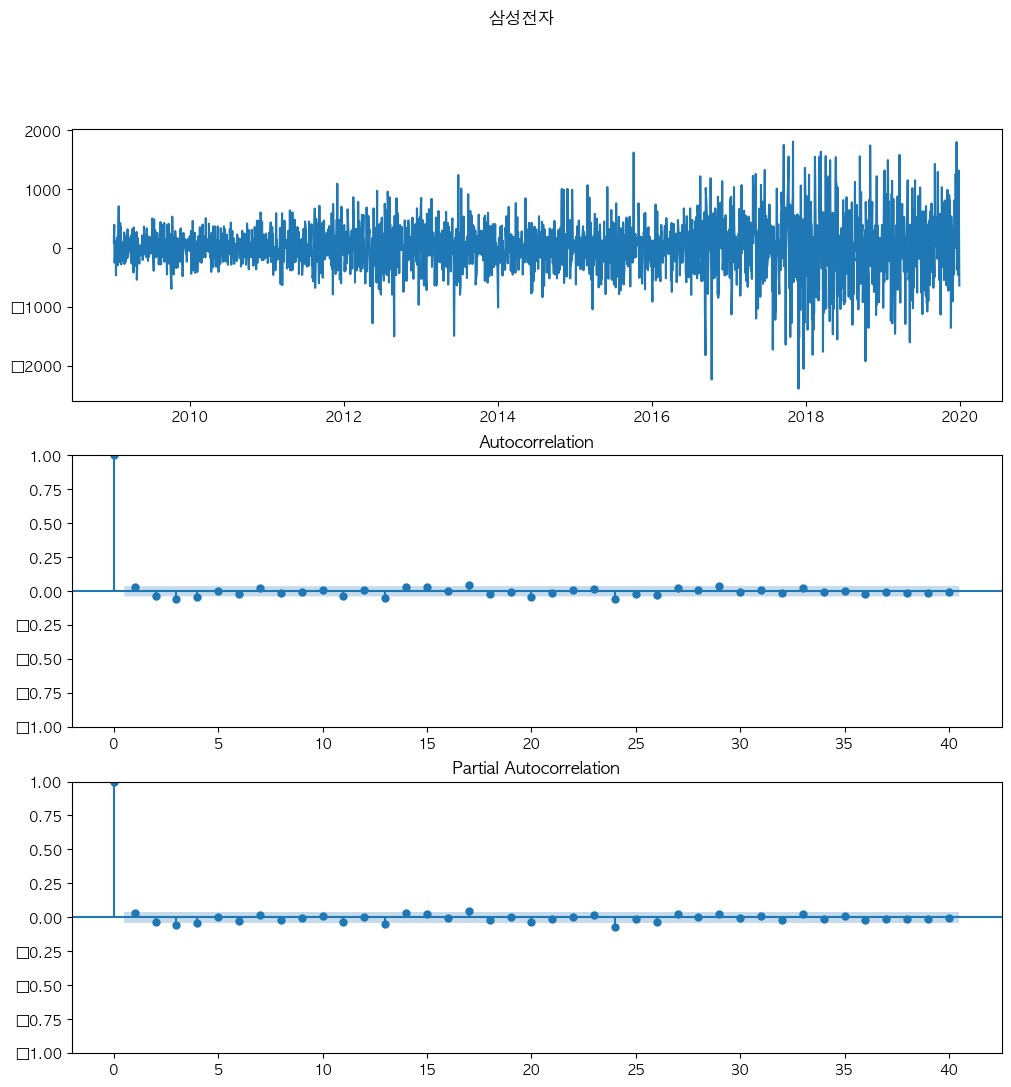

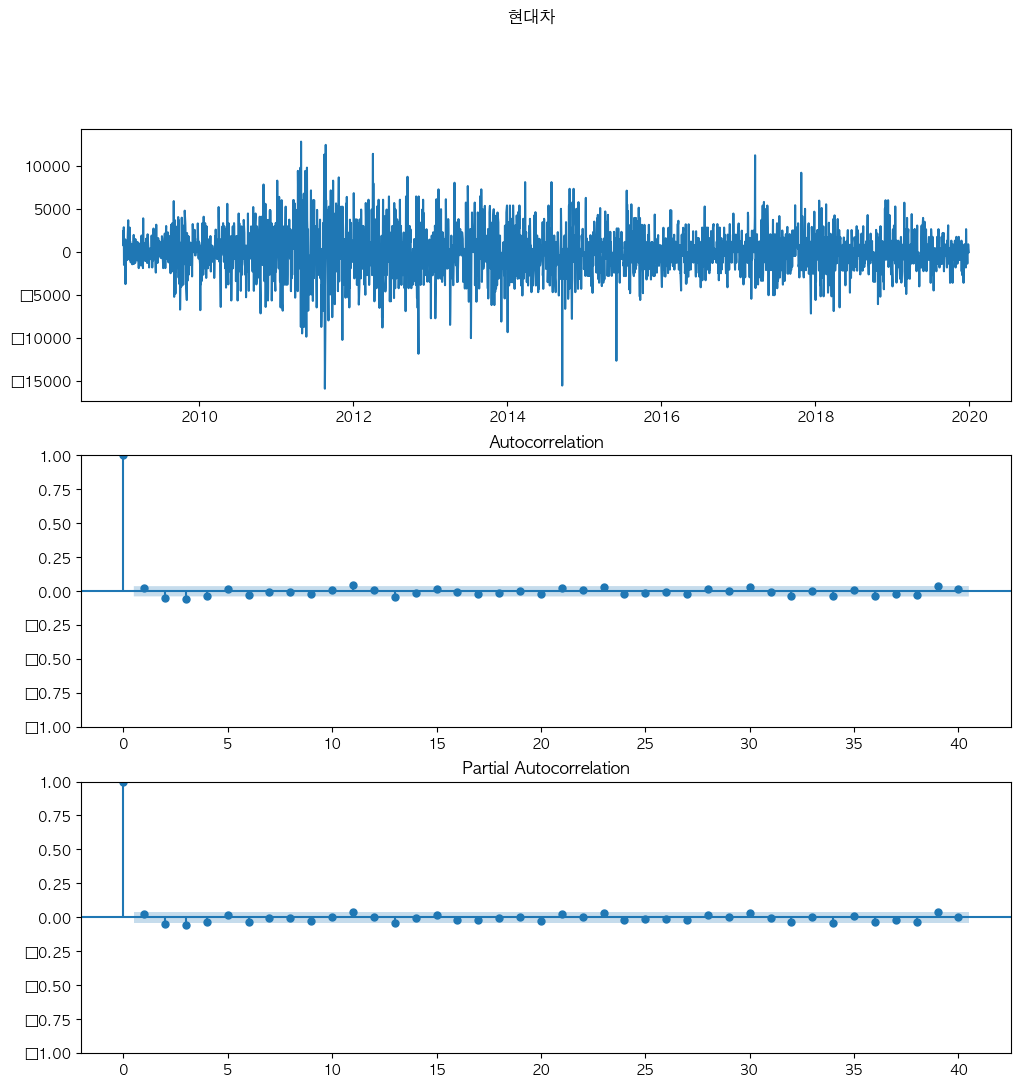

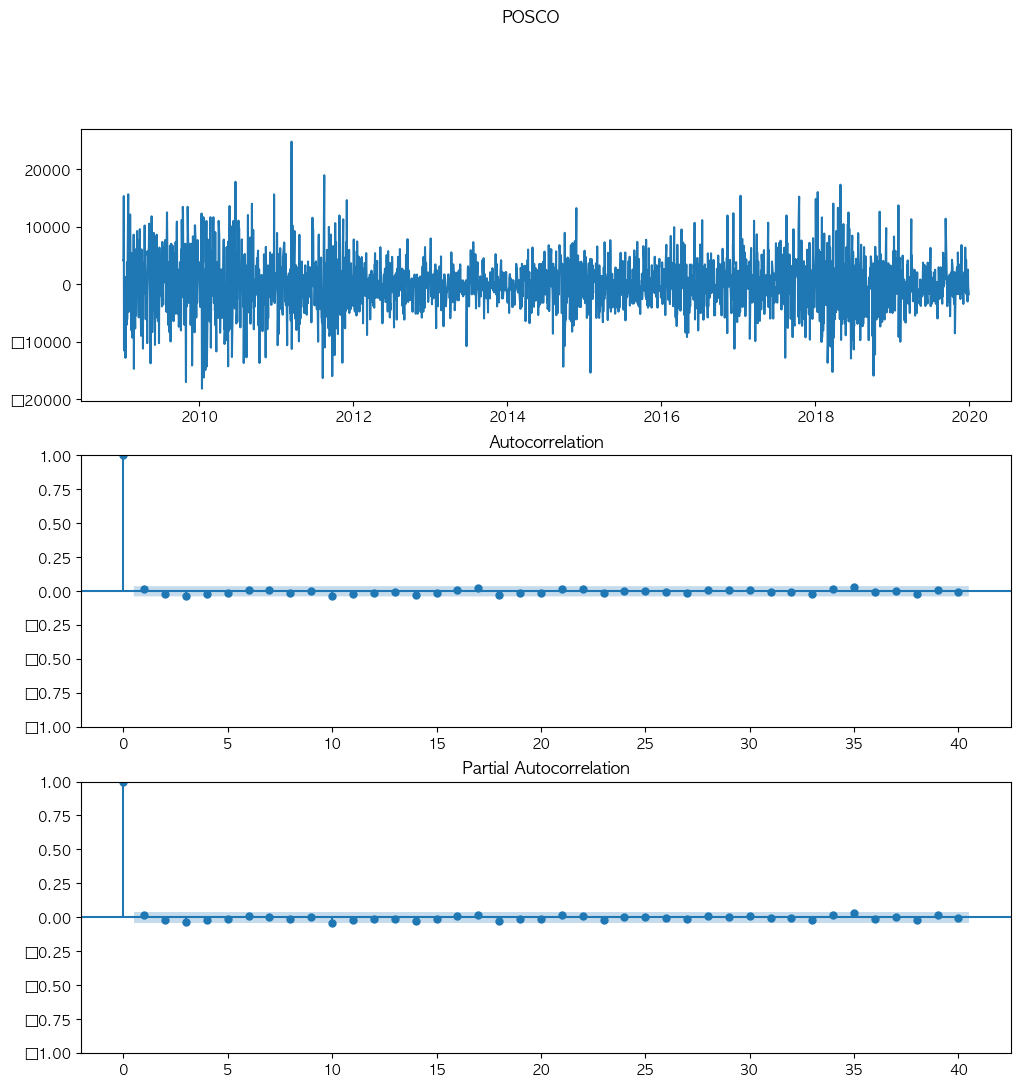

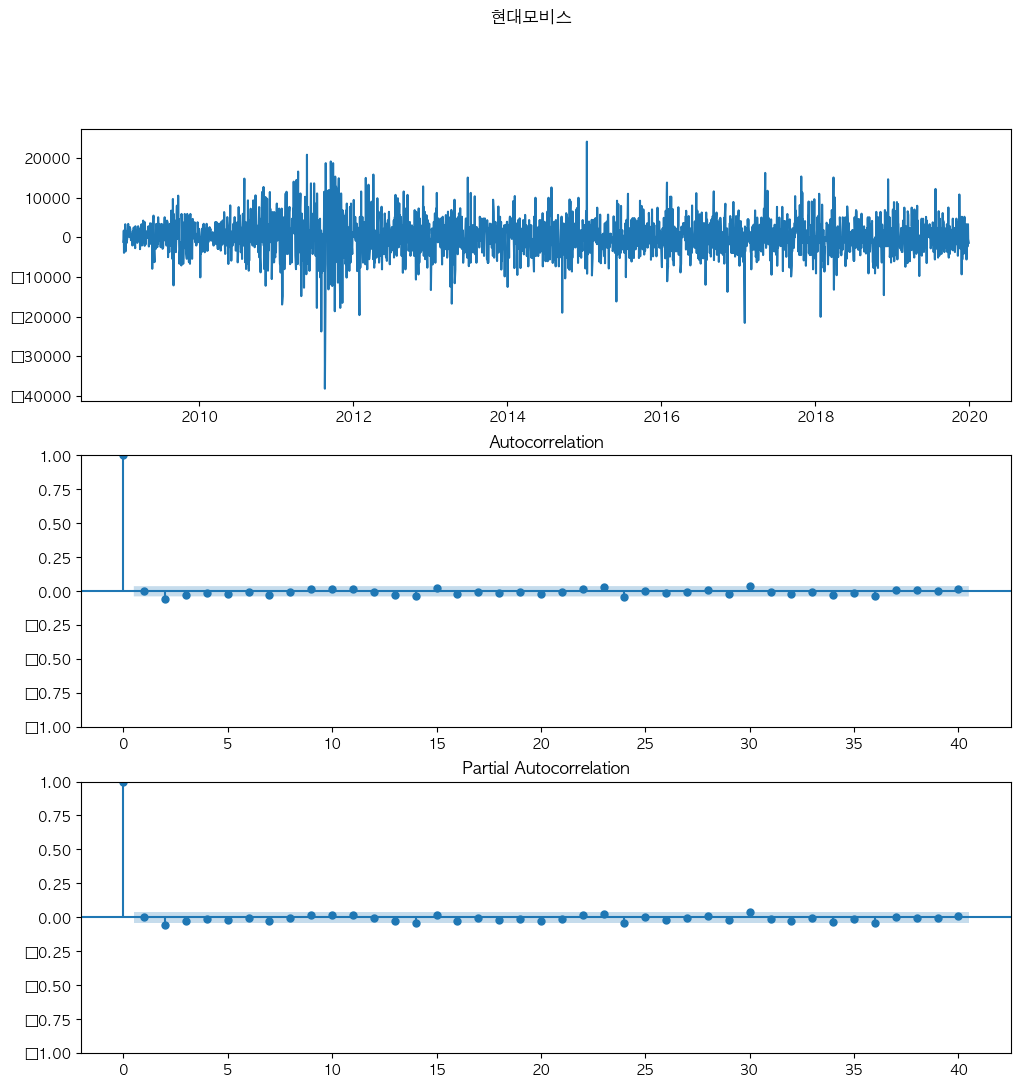

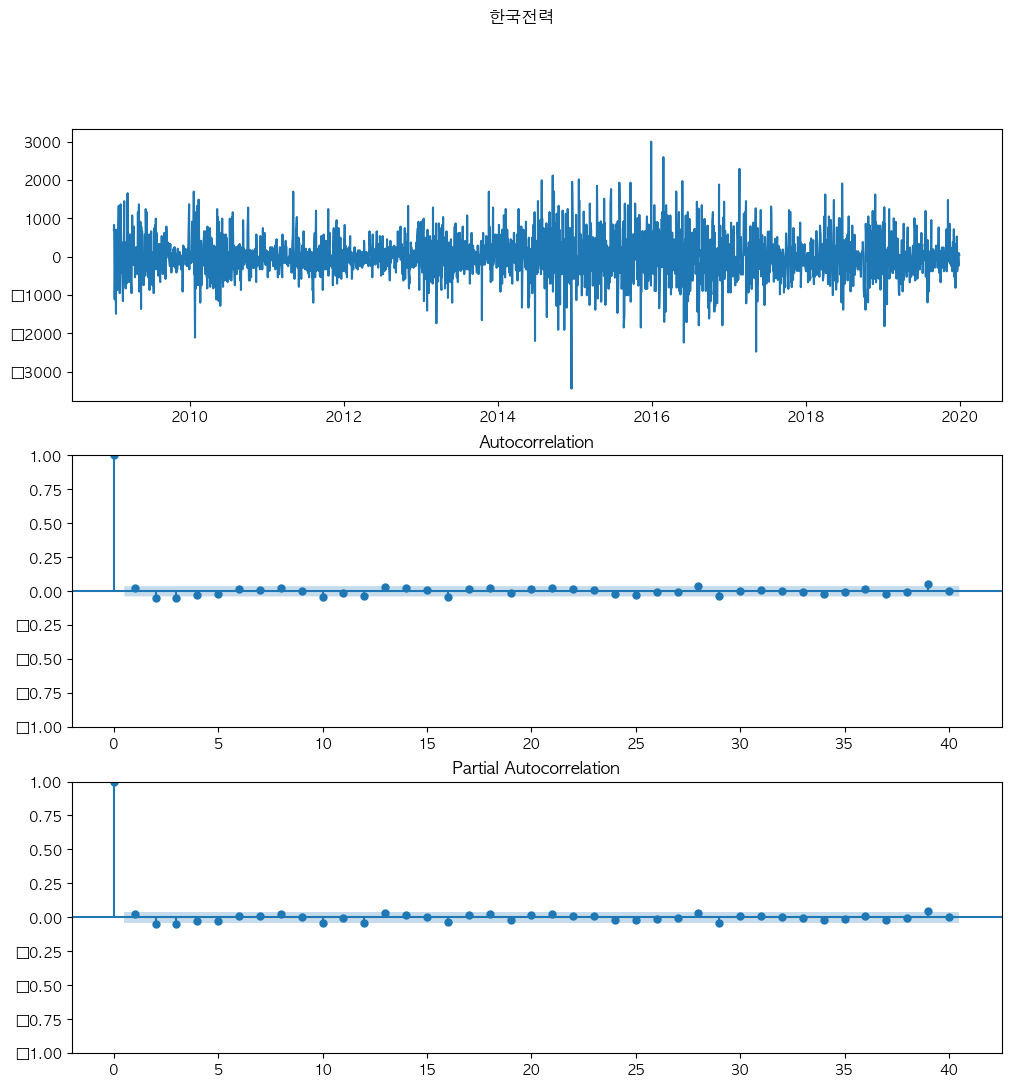

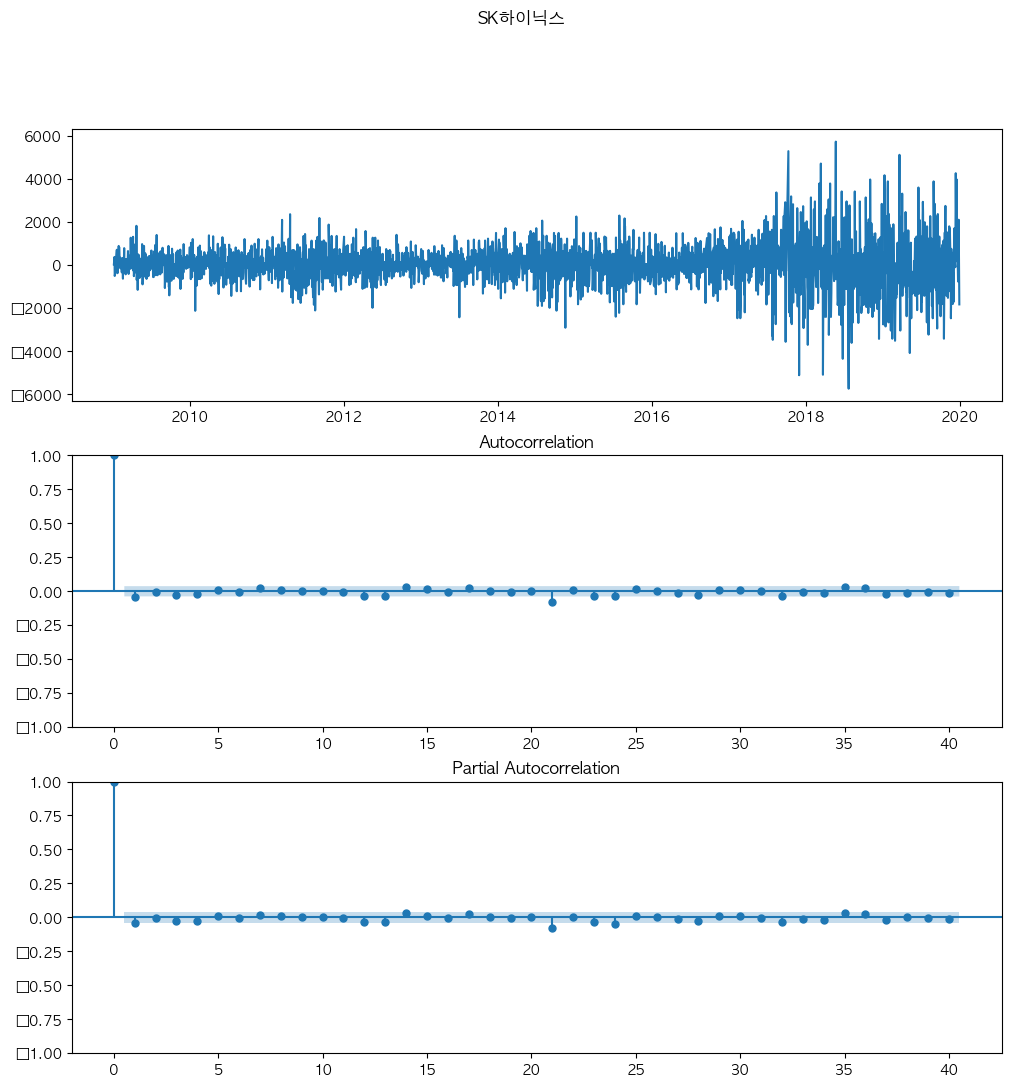

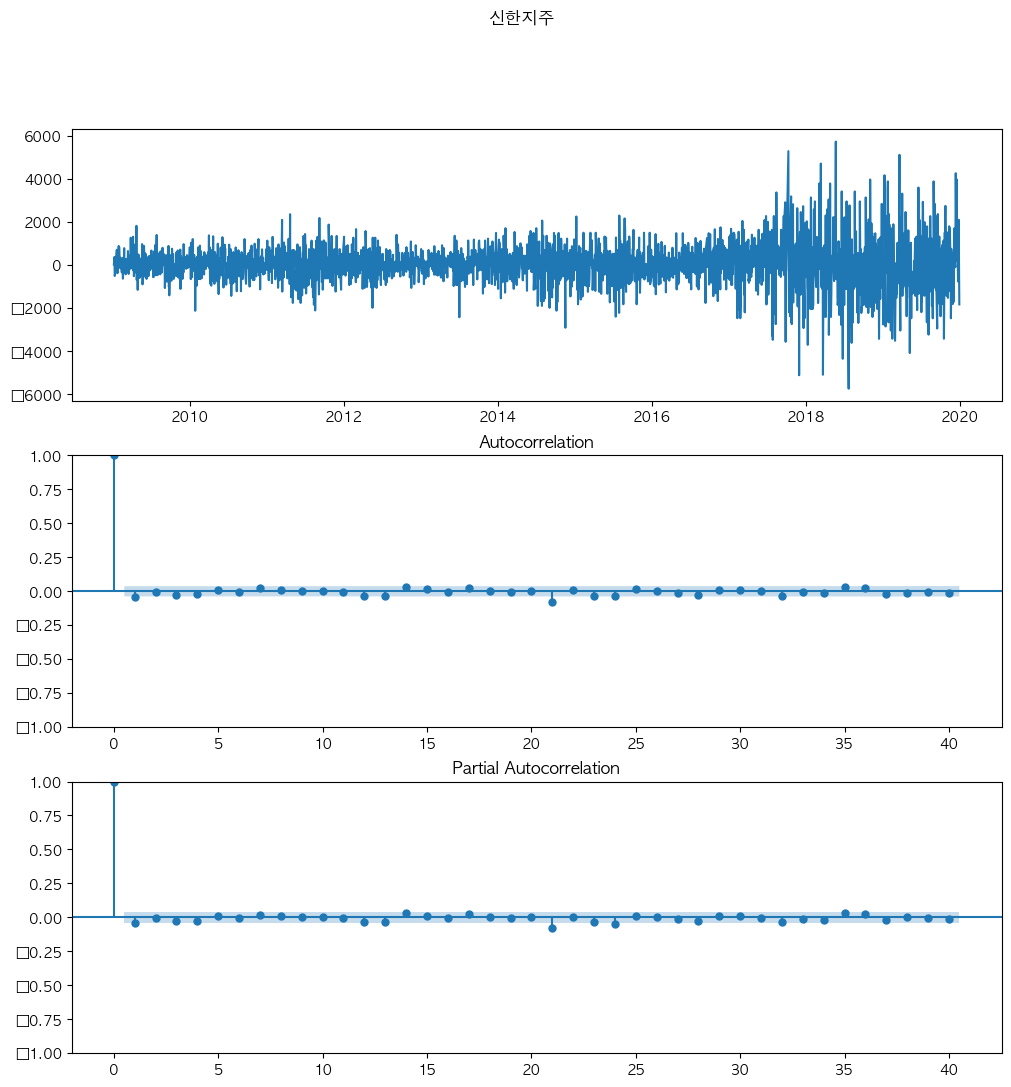

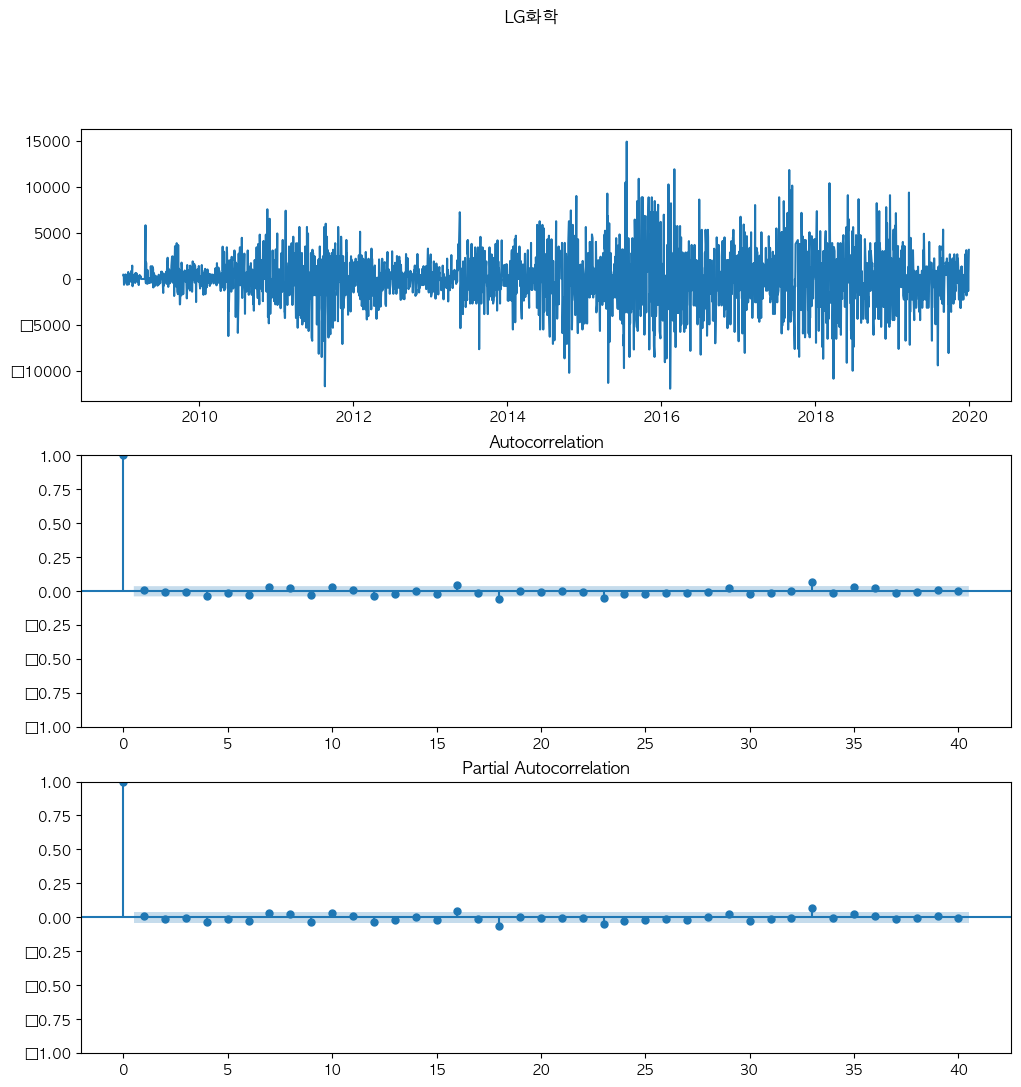

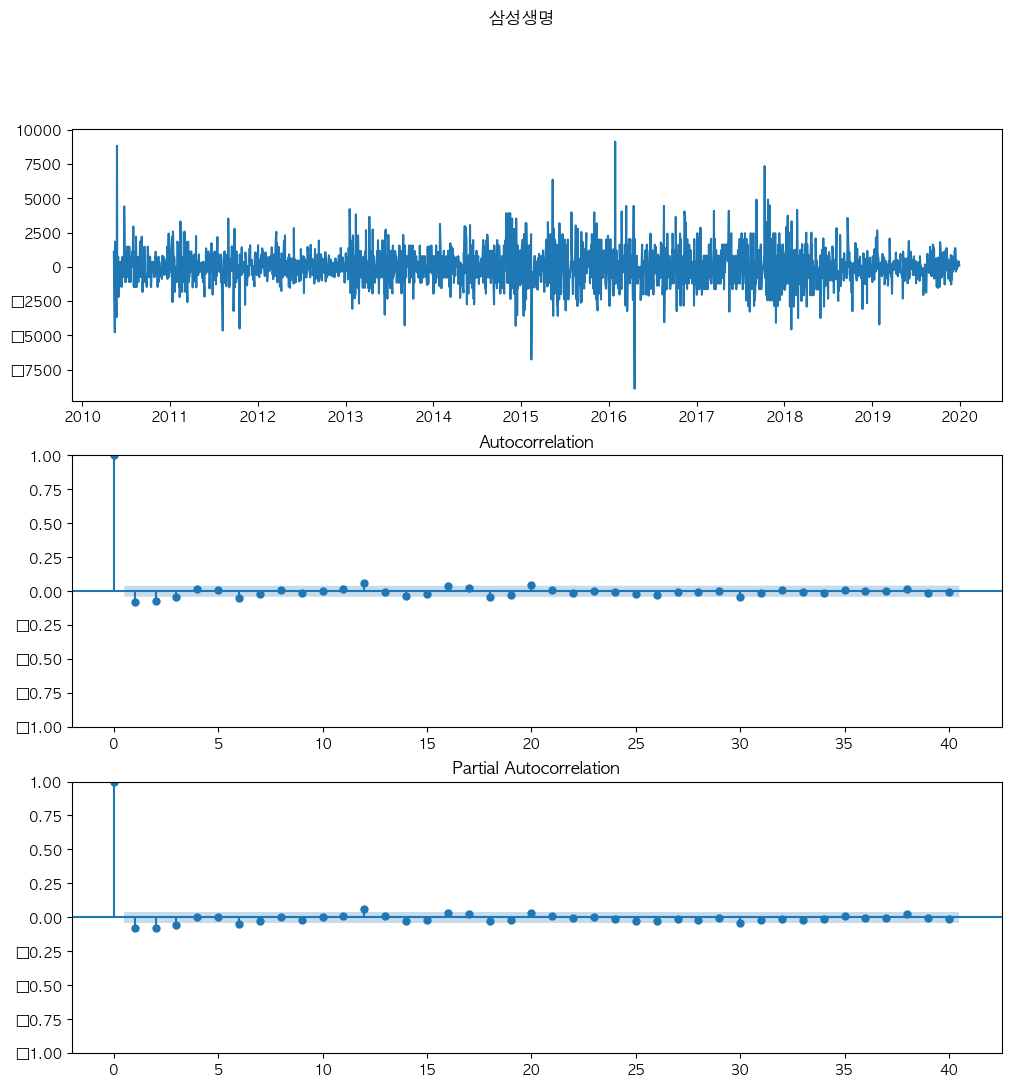

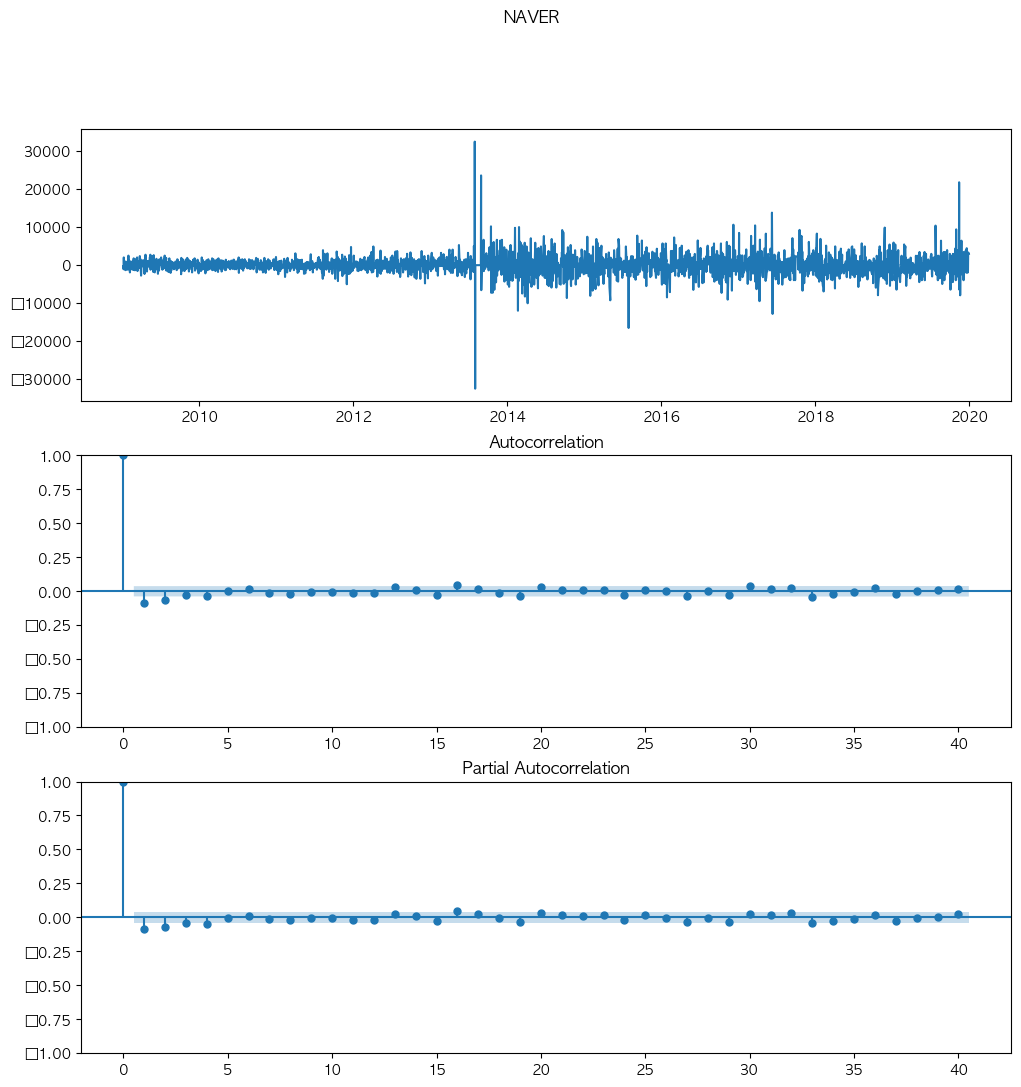

In [79]:
# 5. 차분 진행
for k, v in st.items():    
    # 적절한 차분 횟수 확인
    # alpha는 adf테스트에서 사용되는 유의 수준!
    diff = ndiffs(v['Adj Close'], test='adf', alpha=0.05, max_d=5)

    # 차분 진행!
    if diff >= 1:
        diff_train = v.diff(diff).dropna()
    
    
    # 차분 후 acf, pacf 그래프 그려보기
    fig, ax = plt.subplots(3, 1, figsize=(12, 12))

    ax[0].plot(diff_train.index, diff_train['Adj Close'])
    plot_acf(diff_train['Adj Close'], lags=40 ,ax=ax[1])
    plot_pacf(diff_train['Adj Close'], lags=40 ,ax=ax[2])
    
    plt.suptitle(k)


In [ ]:
# 6. parameter search(어떤 모델을 사용할지 설정)
for k, v in st.items():
    df_train, df_test = train_test_split(v, test_size=0.1, shuffle=False ,random_state=42)

    diff = ndiffs(v['Adj Close'], test='adf', alpha=0.05, max_d=5)

    # 차분 진행!
    if diff >= 1:
        diff_train = v.diff(diff).dropna()
    
    # p(AR) : 자기회귀의 차수, 이전시점의 데이터와 얼마나 상관관계를 갖는가
    # q(MA) : 이동평균의 차수, 이전 시점의 예측 오차얼마나 의존하는가
    model = auto_arima(
        df_train['Adj Close'], start_p=1, start_q=1,
        d=1,
        trace=True,
        error_action='ignore',
        stepwise=False,
        suppress_warnings=True
    )
    print(model.summary())

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=37922.242, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=inf, Time=1.29 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=37342.556, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.51 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.15 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=37103.527, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.81 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.23 sec
 ARIMA(3,1,0)(0,0,0)[1] intercept   : AIC=36934.175, Time=0.28 sec


In [83]:
# 7. 모델 예측
for k, v in st.items():
    # model.predict를 통해 미래값을 예측하는데 사용!
    # forecast 는 예측된 값, conf_int : 예측 구간
    forecast = model.predict(len(df_test), return_conf_int=True, start=df_test.index[0], end=df_test.index[-1])

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predicti

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=36307.425, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=36307.583, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=36303.438, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=36293.076, Time=0.32 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=36290.857, Time=0.37 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=36292.827, Time=0.46 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=36307.761, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=36308.357, Time=0.34 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=36290.104, Time=0.56 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=36292.898, Time=0.39 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=36292.853, Time=0.39 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=36303.131, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=36289.431, Time=0.64 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=36291.027, Time=0.77 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=36292.215, Time=1.18

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


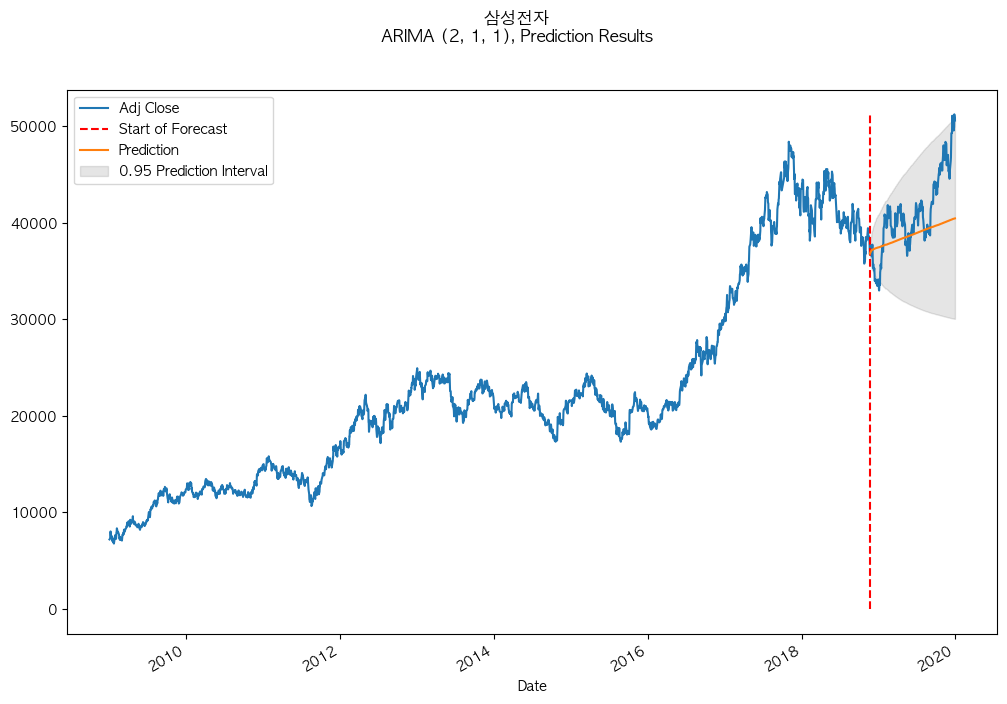

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=45681.528, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=45681.511, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=45680.068, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=45674.305, Time=0.28 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=45670.431, Time=0.33 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=45671.991, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=45681.656, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=45679.830, Time=0.31 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=45673.082, Time=0.44 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=45672.325, Time=0.51 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=45671.319, Time=0.62 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=45679.853, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=45672.196, Time=0.42 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=45673.203, Time=0.49 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=45674.183, Time=0.66

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


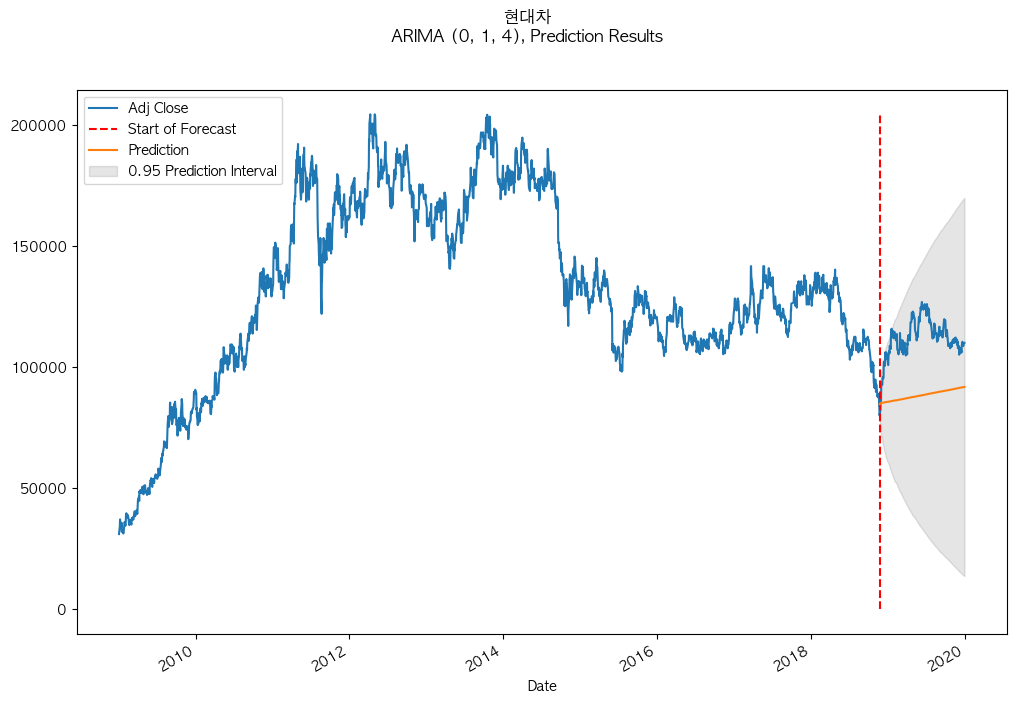

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=48097.440, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=48097.877, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=48099.861, Time=0.18 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=48100.349, Time=0.34 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=48096.687, Time=0.35 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=48093.064, Time=0.45 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=48097.834, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=48098.582, Time=0.26 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=48097.350, Time=0.42 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=48096.917, Time=0.59 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=48089.054, Time=0.79 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=48099.788, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=48100.610, Time=0.55 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=48100.967, Time=0.41 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=48092.424, Time=1.22

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


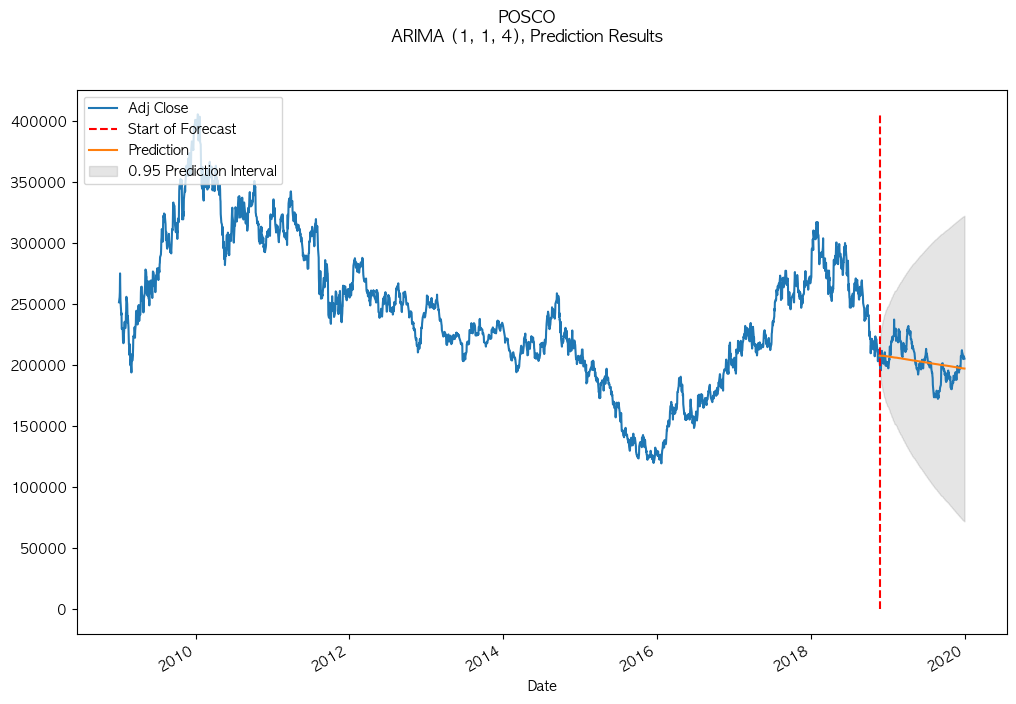

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=48172.345, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=48174.219, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=48168.297, Time=0.23 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=48167.749, Time=0.23 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=48168.778, Time=0.33 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=48170.178, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=48174.231, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=48172.846, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=48166.866, Time=0.41 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=48168.747, Time=0.46 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=48170.622, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=48168.517, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=48166.780, Time=0.29 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=48168.863, Time=0.53 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=48170.429, Time=0.59

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


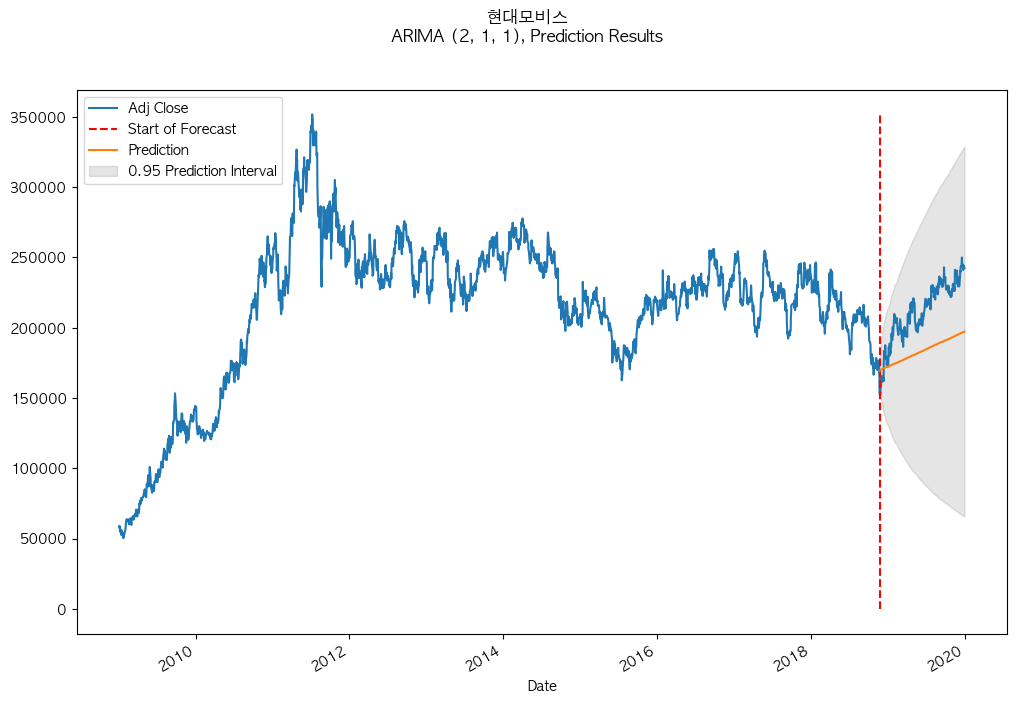

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=37843.729, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=37843.316, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=37840.273, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=37837.009, Time=0.31 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=37837.467, Time=0.37 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=37835.721, Time=0.39 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=37843.527, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=37843.916, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=37834.301, Time=0.37 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=37836.034, Time=0.49 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=37837.975, Time=0.60 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=37839.982, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=37834.040, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=37834.675, Time=0.67 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=37837.637, Time=0.75

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


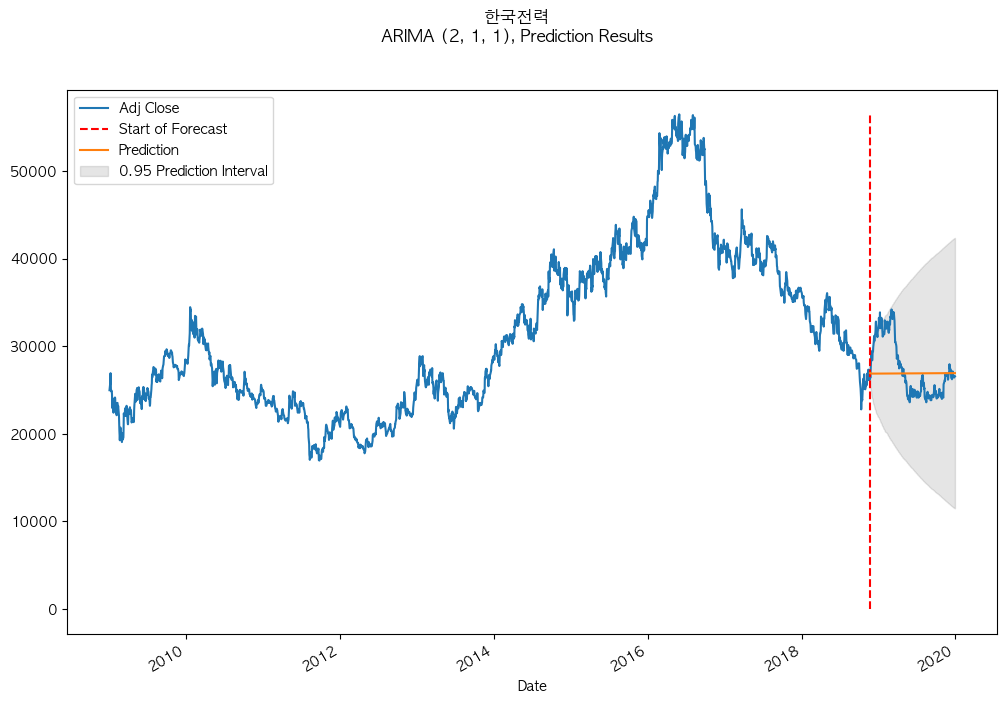

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=40048.782, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=40043.321, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=40044.628, Time=0.27 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=40037.608, Time=0.31 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=40039.390, Time=0.37 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=40038.984, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=40043.535, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=40043.538, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=40045.303, Time=0.38 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=40039.558, Time=0.47 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=40039.994, Time=0.41 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=40045.119, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=40045.457, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=40044.401, Time=0.58 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=40039.597, Time=0.55

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


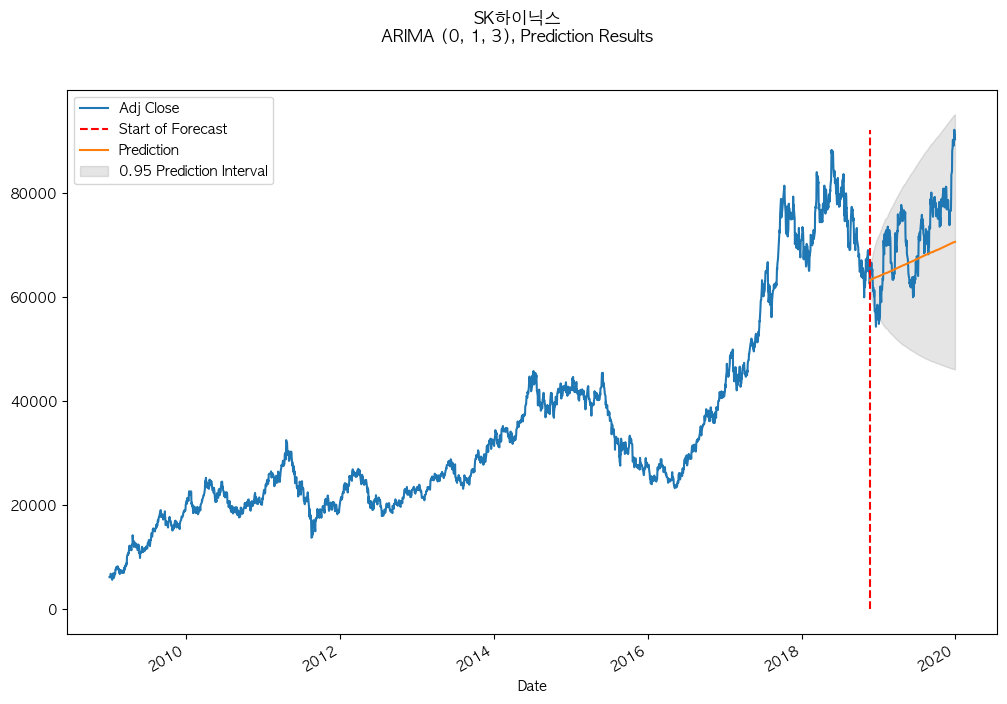

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=37585.684, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=37587.698, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=37585.226, Time=0.20 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=37579.810, Time=0.30 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=37575.584, Time=0.36 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=37576.913, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=37587.699, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=37589.743, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=37571.990, Time=0.55 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=37573.692, Time=0.75 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=37576.544, Time=0.71 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=37585.763, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=37571.931, Time=0.67 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=37573.869, Time=0.83 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=37575.703, Time=1.20

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


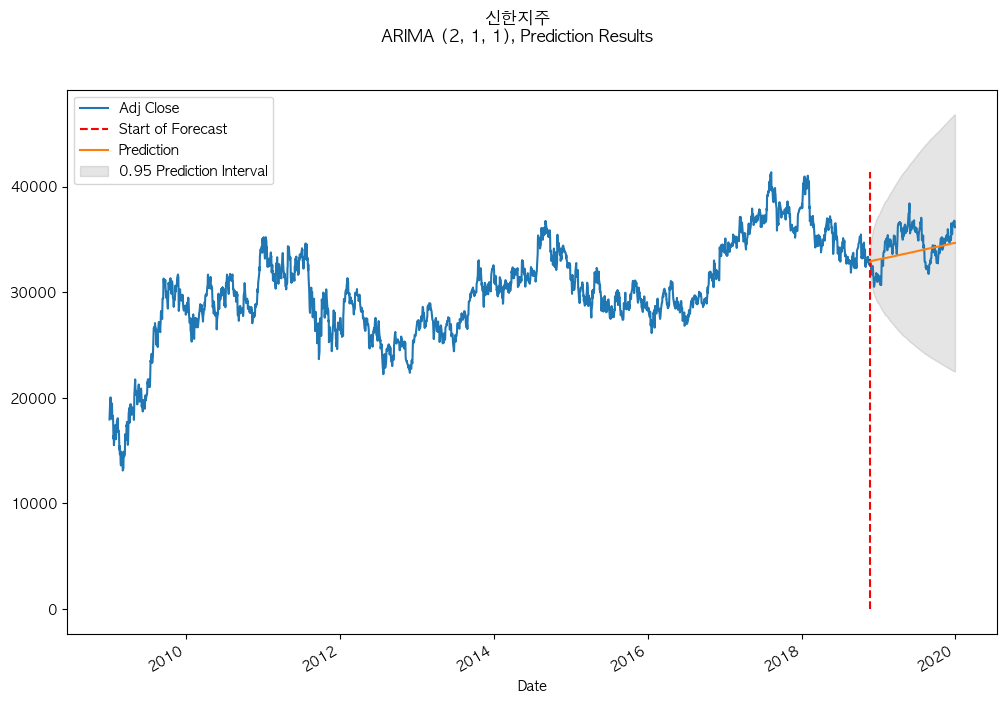

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=45697.148, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=45698.863, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=45700.580, Time=0.19 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=45702.537, Time=0.19 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=45700.775, Time=0.33 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=45701.493, Time=0.47 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=45698.866, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=45699.596, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=45701.458, Time=0.54 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=45704.619, Time=0.36 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=45701.801, Time=0.60 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=45700.596, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=45701.470, Time=0.42 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=45703.088, Time=0.60 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=45704.914, Time=0.87

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


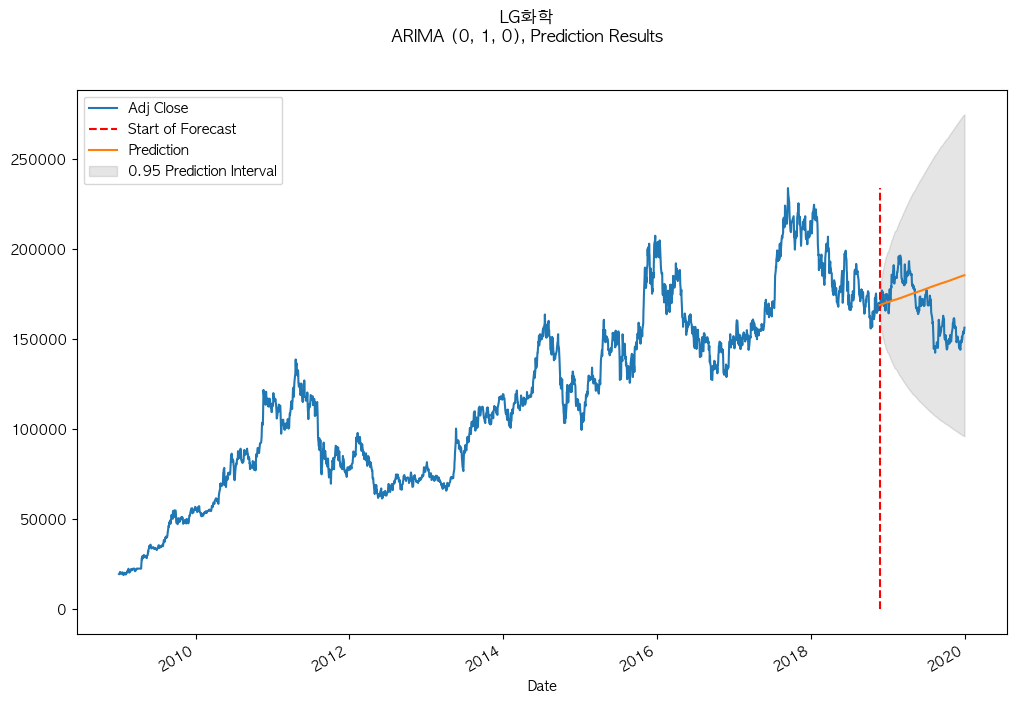

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=36799.028, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=36794.311, Time=0.06 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=36783.061, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=36766.317, Time=0.37 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=36768.072, Time=0.39 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=36769.428, Time=0.49 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=36794.996, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=36771.765, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=36771.433, Time=0.18 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=36767.934, Time=0.63 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=36769.992, Time=0.82 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=36785.489, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=36771.214, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=36773.144, Time=0.52 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=36769.916, Time=0.49

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


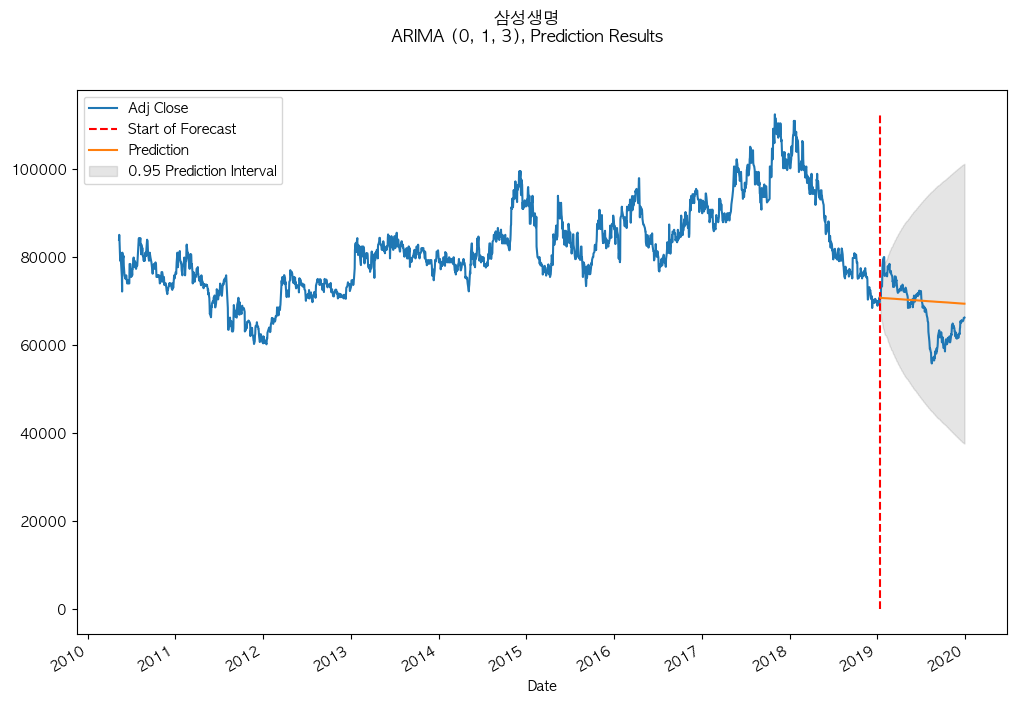

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=45273.336, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=45258.575, Time=0.07 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=45244.857, Time=0.29 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=45246.107, Time=0.34 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=45246.622, Time=0.36 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=45248.369, Time=0.43 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=45261.179, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=45246.188, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=45245.709, Time=0.55 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=45247.695, Time=0.54 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=45248.610, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=45247.220, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=45245.871, Time=0.37 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=45246.970, Time=0.58 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=45248.977, Time=0.52

/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/homebrew/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


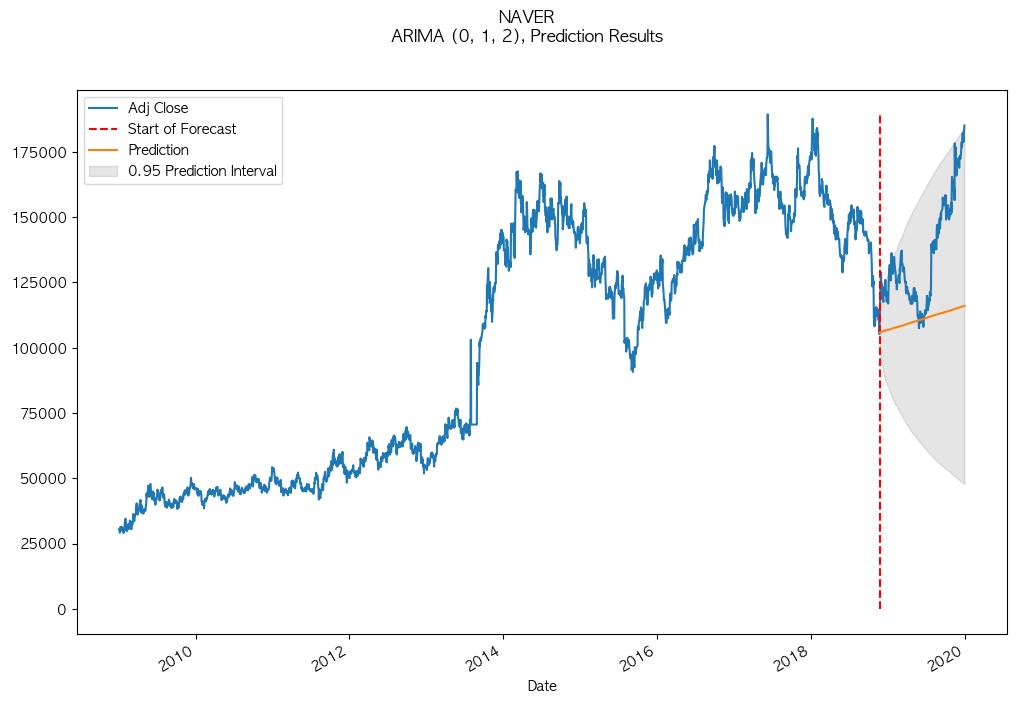

In [94]:
# 8. 그래프를 통한 예측결과 확인
for k, v in st.items():
    df_train, df_test = train_test_split(v, test_size=0.1, shuffle=False ,random_state=42)

    model = auto_arima(
    df_train['Adj Close'], start_p=1, start_q=1,
    d=1,
    trace=True,
    error_action='ignore',
    stepwise=False,
    suppress_warnings=True
    )
    
    # model.predict를 통해 미래값을 예측하는데 사용!
    # forecast 는 예측된 값, conf_int : 예측 구간
    forecast = model.predict(len(df_test), return_conf_int=True, start=df_test.index[0], end=df_test.index[-1])

    forecast_value = forecast[0]
    forecast_lb = forecast[1][:,0]
    forecast_ub = forecast[1][:,1]
    forecast_index = list(df_test.index)

    fig, ax = plt.subplots(figsize=(12, 8))
    v['Adj Close'].plot()
    ax.vlines(forecast_index[0],0, max(v['Adj Close']), linestyle='--',color='r', label='Start of Forecast')
    ax.plot(forecast_index, forecast_value, label='Prediction')
    ax.fill_between(forecast_index, forecast_lb, forecast_ub, color='k', alpha=0.1, label='0.95 Prediction Interval')
    ax.legend(loc='upper left')
    plt.suptitle(f'{k}\nARIMA {model.order}, Prediction Results')
    plt.show()
    

## VAR 모델
- Vector AutoRegressive Model
- 다변량 시계열 모델(다수의 feature)
- AR을 벡터로 쌓음으로써 2개 이상의 시계열을 동시에 모형화 할 수 있다.
- 변수들 간의 의존성을 고려해야한다!

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.tsa.api import VAR



In [357]:
interest = pd.read_csv('./시장금리(일별)_03172153.csv', index_col=0, names=['CD', '국고채', '회사채'])
interest = interest[1:]

from datetime import datetime
interest.index = pd.to_datetime(interest.index)
interest['회사채'] = interest['회사채'].astype(float)

int_dict = {}

for key, value in st.items():
    
    var = pd.concat([interest,value['Adj Close']], axis=1)
    int_dict[key] = var

In [261]:
interest.head()

,CD,국고채,회사채
2009-01-02,3.93,4.250,7.73
2009-01-05,3.92,4.220,7.51
2009-01-06,3.92,4.240,7.46
2009-01-07,3.92,4.350,7.45
2009-01-08,3.25,4.160,7.25


/opt/homebrew/lib/python3.11/site-packages/seaborn/utils.py:61: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

/opt/homebrew/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


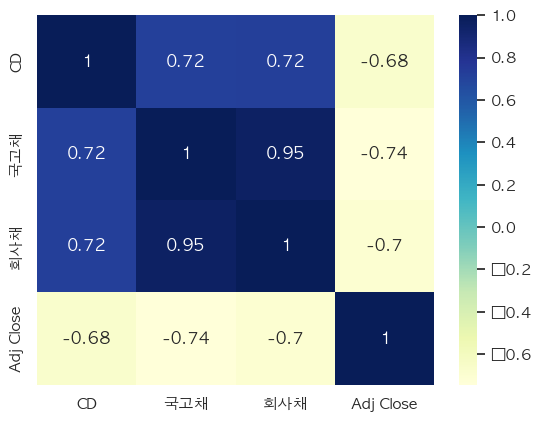

In [358]:
plt.rc('font', family='AppleGothic')

sam_df = int_dict['삼성전자']
corr = sam_df.corr()

sns.heatmap(corr, annot=True, cmap='YlGnBu')